In [1]:
import csv
import itertools
from matplotlib import pyplot as plt
import numpy as np

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC

from sklearn.linear_model import LogisticRegression

# import warnings
# warnings.filterwarnings("ignore")

### Read the data

In [2]:
with open('creditcard.csv', newline='') as f:
    reader = csv.reader(f, delimiter=',')
    csv_data = list(reader)[1:]

# Format: Time, V1, ..., V28, Amount, Class
data = np.array([[float(x) for x in row[1:-1]] for row in csv_data])
times = np.array([float(row[0]) for row in csv_data])
labels = np.array([int(row[-1]) for row in csv_data])
print('The data is imbalanced, with {} samples in total but only {} cases of fraud'.format(len(labels), sum(labels)))

The data is imbalanced, with 284807 samples in total but only 492 cases of fraud


### Feature Scaling

In [3]:
print(np.mean(data, axis=0))
print(np.var(data, axis=0))
print('The PCA features have mean 0 but different variances')
print('The transaction amount is not scaled. We should scale it so it does not affect the SVM too much')

[ 3.91864870e-15  5.68268579e-16 -8.76173610e-15  2.81111774e-15
 -1.55210305e-15  2.04012968e-15 -1.69895265e-15 -1.95815061e-16
 -3.14764036e-15  1.77292451e-15  9.28952385e-16 -1.80326603e-15
  1.67488824e-15  1.47562122e-15  3.50109813e-15  1.39243845e-15
 -7.46653801e-16  4.25873794e-16  9.02016885e-16  5.12684532e-16
  1.47198194e-16  8.04210901e-16  5.28245009e-16  4.45826738e-15
  1.42689564e-15  1.70163965e-15 -3.67160561e-16 -1.21815215e-16
  8.83496193e+01]
[3.83647578e+00 2.72681045e+00 2.29902117e+00 2.00467678e+00
 1.90507436e+00 1.77494002e+00 1.53039520e+00 1.42647385e+00
 1.20698823e+00 1.18558965e+00 1.04185143e+00 9.98399911e-01
 9.90567315e-01 9.18902320e-01 8.37800459e-01 7.67816427e-01
 7.21370915e-01 7.02536891e-01 6.62659610e-01 5.94323307e-01
 5.39523633e-01 5.26640906e-01 3.89949292e-01 3.66807083e-01
 2.71729873e-01 2.32542076e-01 1.62918619e-01 1.08954579e-01
 6.25598494e+04]
The PCA features have mean 0 but different variances
The transaction amount is not 

In [4]:
scaler = StandardScaler()
data_sc = scaler.fit_transform(data)
print(np.mean(data_sc, axis=0))
print(np.var(data_sc, axis=0))

[-2.25678488e-15 -1.71239117e-16  1.78595723e-16 -1.28963171e-15
  1.58007541e-15 -9.37326021e-17 -4.94536068e-17  5.94282165e-17
  1.06682404e-15  4.52466744e-16  2.44123467e-15  2.51412842e-15
 -9.21023919e-16 -1.01232363e-15 -1.29522625e-16 -9.85596926e-17
  1.19923593e-15  3.18853147e-16 -1.67186006e-16  4.18564063e-16
  8.94645076e-17 -3.51601875e-16 -1.16601660e-15  1.28679343e-16
 -2.51010111e-15  2.03088636e-16 -7.54884618e-18  1.28996763e-16
  2.27024770e-13]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1.]


### Preliminary plotting

[ 1.19185711 -1.35835406 -0.96627171 -1.15823309 -0.42596588  1.22965763
 -0.64426944 -0.89428608 -0.33826175]


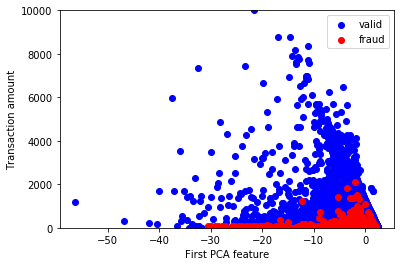

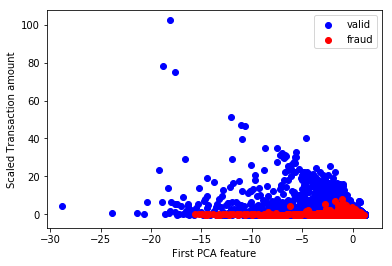

In [ ]:
# plot the first two principal components
data_fraud = data[np.where(labels == 1)]
data_valid = data[np.where(labels == 0)]
plt.scatter(data_valid[:, 0], data_valid[:, -1], c='b')
plt.scatter(data_fraud[:, 0], data_fraud[:, -1], c='r')
print(data_valid[1:10, 0])
plt.ylim((0, 10000))
plt.legend(['valid', 'fraud'])
plt.xlabel('First PCA feature')
plt.ylabel('Transaction amount')
plt.show()

data_fraud_sc = data_sc[np.where(labels == 1)]
data_valid_sc = data_sc[np.where(labels == 0)]
plt.scatter(data_valid_sc[:, 0], data_valid_sc[:, -1], c='b')
plt.scatter(data_fraud_sc[:, 0], data_fraud_sc[:, -1], c='r')
# plt.ylim((0, 10000))
plt.legend(['valid', 'fraud'])
plt.xlabel('First PCA feature')
plt.ylabel('Scaled Transaction amount')
plt.show()

### Setting up cross-validation

In [ ]:
fraud_indices = np.where(labels == 1)[0]
np.random.shuffle(fraud_indices)
fraud_splits = np.array_split(fraud_indices, 5)

valid_indices = np.where(labels == 0)[0]
np.random.shuffle(valid_indices)
valid_splits = np.array_split(valid_indices, 5)

folds = [np.concatenate((fraud_sp, valid_sp)) for fraud_sp, valid_sp in zip(fraud_splits, valid_splits)]

### SVM

In [ ]:
def train_binary_SVM(data, kernel=None, class_weight=None):
    confusion_mat = np.zeros((2, 2))
    for i in range(5):
        if kernel is None:
            if class_weight is None:
                svm = LinearSVC(fit_intercept=False, dual=False)
            else:
                svm = LinearSVC(fit_intercept=False, dual=False, class_weight=class_weight)
        else:
            if class_weight is None:
                svm = SVC(kernel=kernel, gamma='auto')
            else:
                svm = SVC(kernel=kernel, gamma='auto', class_weight=class_weight)

        svm.fit(np.delete(data, folds[i], axis=0), np.delete(labels, folds[i]))
        pred = svm.predict(data[folds[i]])

        conf_mat = confusion_matrix(labels[folds[i]], pred)
        print('Fold', i)
        print(conf_mat)

        confusion_mat += conf_mat

    confusion_mat /= 5
    print('Final Confusion Matrix')
    print(confusion_mat)
    print('False negatives (valid):', confusion_mat[0, 1] / sum(confusion_mat[0, :]))
    print('False positives (fraud):', confusion_mat[1, 0] / sum(confusion_mat[1,:]))
    return confusion_mat

#### Linear SVM -- Without scaling or class weights

In [ ]:
train_binary_SVM(data);

Fold 0
[[56808    55]
 [   37    62]]
Fold 1
[[56835    28]
 [   39    60]]
Fold 2
[[56831    32]
 [   31    67]]
Fold 3
[[56810    53]
 [   33    65]]
Fold 4
[[56831    32]
 [   40    58]]
Final Confusion Matrix
[[5.6823e+04 4.0000e+01]
 [3.6000e+01 6.2400e+01]]
False negatives (valid): 0.0007034451224873819
False positives (fraud): 0.36585365853658536


#### Linear SVM with Scaling

In [ ]:
train_binary_SVM(data_sc);

Fold 0
[[51173  5690]
 [    7    92]]
Fold 1
[[46879  9984]
 [    6    93]]
Fold 2
[[46958  9905]
 [    3    95]]
Fold 3
[[49623  7240]
 [    6    92]]
Fold 4
[[46147 10716]
 [    1    97]]
Final Confusion Matrix
[[4.8156e+04 8.7070e+03]
 [4.6000e+00 9.3800e+01]]
False negatives (valid): 0.15312241703744087
False positives (fraud): 0.046747967479674794


#### Linear SVM with Scaling and Class Weights

In [ ]:
train_binary_SVM(data_sc, class_weight='balanced');

Fold 0
[[34601 22262]
 [    2    97]]
Fold 1
[[34961 21902]
 [    0    99]]
Fold 2
[[33554 23309]
 [    1    97]]
Fold 3
[[34183 22680]
 [    1    97]]
Fold 4
[[33128 23735]
 [    2    96]]
Final Confusion Matrix
[[3.40854e+04 2.27776e+04]
 [1.20000e+00 9.72000e+01]]
False negatives (valid): 0.40056979054921477
False positives (fraud): 0.012195121951219511


### Kernel SVM

#### RBF Kernel with Scaling and Class Weights

In [ ]:
train_binary_SVM(data_sc, kernel='rbf');

Fold 0
[[56860     3]
 [   35    64]]
Fold 1
[[56859     4]
 [   32    67]]
Fold 2
[[56858     5]
 [   20    78]]
Fold 3
[[56859     4]
 [   35    63]]
Fold 4
[[56863     0]
 [   34    64]]
Final Confusion Matrix
[[5.68598e+04 3.20000e+00]
 [3.12000e+01 6.72000e+01]]
False negatives (valid): 5.627560979899056e-05
False positives (fraud): 0.31707317073170727


In [ ]:
train_binary_SVM(data_sc, kernel='rbf', class_weight='balanced');

Fold 0
[[56726   137]
 [   29    70]]
Fold 1
[[56729   134]
 [   27    72]]
Fold 2
[[56692   171]
 [   16    82]]
Fold 3
[[56705   158]
 [   26    72]]
Fold 4
[[56696   167]
 [   26    72]]
Final Confusion Matrix
[[5.67096e+04 1.53400e+02]
 [2.48000e+01 7.36000e+01]]
False negatives (valid): 0.00269771204473911
False positives (fraud): 0.2520325203252033


#### Polynomial Kernel with Scaling and Class Weights

In [ ]:
train_binary_SVM(data_sc, kernel='poly');

Fold 0
[[56851    12]
 [   27    72]]
Fold 1
[[56852    11]
 [   25    74]]
Fold 2
[[56857     6]
 [   16    82]]
Fold 3
[[56855     8]
 [   25    73]]
Fold 4
[[56862     1]
 [   23    75]]
Final Confusion Matrix
[[5.68554e+04 7.60000e+00]
 [2.32000e+01 7.52000e+01]]
False negatives (valid): 0.00013365457327260257
False positives (fraud): 0.23577235772357721


In [ ]:
train_binary_SVM(data_sc, kernel='poly', class_weight='balanced');

Fold 0
[[56621   242]
 [   31    68]]
Fold 1
[[56651   212]
 [   25    74]]
Fold 2
[[56628   235]
 [   16    82]]
Fold 3
[[56640   223]
 [   26    72]]


### Logistic Regression

In [ ]:
def train_logistic_regression(data, class_weight = None, C=1.0):
    err = 0
    err_valid = 0
    err_fraud = 0
    for i in range(5):
        model = LogisticRegression(class_weight=class_weight, C=C)
        
        model.fit(np.delete(data, folds[i], axis=0), np.delete(labels, folds[i]))
        pred = model.predict(data[folds[i]])
        err_fold = np.sum((pred - labels[folds[i]])**2) / len(folds[i])
        pred_valid = model.predict(data[valid_splits[i]])
        err_valid_fold = np.sum((pred_valid - labels[valid_splits[i]])**2) / len(valid_splits[i])
        pred_fraud = model.predict(data[fraud_splits[i]])
        err_fraud_fold = np.sum((pred_fraud - labels[fraud_splits[i]])**2) / len(fraud_splits[i])
        print('Fold', i, 'Error:', err_fold, 'Valid Error:', err_valid_fold, 'Fraud Error', err_fraud_fold)
        err += err_fold
        err_valid += err_valid_fold
        err_fraud += err_fraud_fold
    err /= 5
    err_valid /= 5
    err_fraud /= 5
    print('FINAL Error:', err, 'Valid Error:', err_valid, 'Fraud Error', err_fraud)
    return err, err_valid, err_fraud

#### Logistic Regression with Scaling, Class Weights, and Regularization

In [ ]:
weights = [None,'balanced']
coefficients = np.logspace(-2,0,10)
fraud_errs = []
param_permuations = list(itertools.product(weights, coefficients))
for cw,C in param_permuations:
    print('Checking class weight {} and coefficient {}'.format(cw, C))
    _,_,fe = train_logistic_regression(data_sc, cw, C)
    fraud_errs.append(fe)

idx = np.argmin(fraud_errs)
best_params = param_permuations[idx]
print('Best parameters found for Logistic Regression is {} class weights and {} coefficient'.format(best_params[0], best_params[1]))

### We see that as we improve fraud accuracy, valid accuracy decreases and vice versa. For the best fraud accuracy, the results suggest that we utilize the scaled data, balanced class weights and a strong regularization (small C coefficient)